In [103]:
import os
from time import time
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [104]:
start_time = time()

In [105]:
consider_distort = False
zoomed_coords = True
num_shots = 1

In [106]:
folder = "data/stars/2016spring/" # images folder
res_folder = 'results/2016spring/' # results folder
coords_folder = 'data/star_coords/2016spring_txt/' # folder with coords files
date = "20160219-001934-484"

In [107]:
# for ipynb
fname_left = folder + os.sep + "mod_" + date + '-1.png'
fname_right = folder + os.sep + "mod_" + date + '-2.png'

# for cmd line run
# fname_left = os.path.abspath(sys.argv[0])
# fname_right = os.path.abspath(sys.argv[1])

In [108]:
img_left = Image.open(fname_left).convert(mode='RGB')
img_right = Image.open(fname_right).convert(mode='RGB')
print """Images loaded as RGB:
%s
%s""" % (fname_left, fname_right)

Images loaded as RGB:
data/stars/2016spring//mod_20160219-001934-484-1.png
data/stars/2016spring//mod_20160219-001934-484-2.png


In [109]:
assert (img_left.size == img_right.size)
w, h = width, height = img_left.size
print 'Original width, height:', w, h

Original width, height: 3137 2347


In [110]:
x_c = img_left.width / 2.0
y_c = img_left.height / 2.0
print 'x_c, y_c:', x_c, y_c

x_c, y_c: 1568.5 1173.5


In [111]:
scatter_img = Image.new('RGB', (width / 2, height / 2), 'white')
s_pix = scatter_img.load()

In [112]:
ELL_RAD = 3

scx_c = scatter_img.width / 2
scy_c = scatter_img.height / 2
draw = ImageDraw.Draw(scatter_img)
draw.ellipse((scx_c-ELL_RAD, scy_c-ELL_RAD, scx_c+ELL_RAD, scy_c+ELL_RAD), fill='black')

In [113]:
align_coeffs = np.loadtxt(res_folder + 'affine_coeffs_shots'+ \
                          str(num_shots) + '_' + date + '.txt')

# HACK! TMP!
# align_coeffs = np.array([1,0,0,1, 240, 39], dtype='float')
# align_coeffs[-2] += 8
# align_coeffs[-1] += 18
np.set_printoptions(precision=12)
print 'Align coeeficients:\n', align_coeffs

Align coeeficients:
[   1.0008989468    0.0037404294   -0.0124173394    1.0032312128
  235.0740805981   47.453581164 ]


In [114]:
a = align_coeffs[0];
b = align_coeffs[1];
c = align_coeffs[2];
d = align_coeffs[3];
e = align_coeffs[4];
f = align_coeffs[5];

det = a * d - b * c;
inv_a = d / det;
inv_b = -b / det;
inv_c = -c / det;
inv_d = a / det;

In [115]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [116]:
z = align_coeffs

a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])
if consider_distort:
    eps1 = float(z[6])
    eps2 = float(z[7])
data = (a, b, e, c, d, f) # affine coefficients

In [117]:
if consider_distort:
    # Get rid of distortions on nlImg
    
    for i in xrange(width): # xi
        for j in xrange(height): # eta
            dist_l = (i-x_c)**2 + (j-y_c)**2

            zx1 = (i - x_c) * dist_l
            zy1 = (j - y_c) * dist_l

            nl_pix[round(i - eps1*zx1), round(j - eps2*zy1)] = l_pix[i, j]
    
    # Get rid of distortions on nrImg

    for i in xrange(width): # xi
        for j in xrange(height): # eta
            dist_r = (i-x_c)**2 + (j-y_c)**2

            zx2 = (i - x_c) * dist_r
            zy2 = (j - y_c) * dist_r

            nr_pix[round(i - eps1*zx2), round(j - eps2*zy2)] = r_pix[i, j]


In [118]:
#Load points

# 20161121
fnames = [
    date + '.txt'
]

In [119]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print 'Zoomed In Star coordinates pairs:\n', coords, '\n'

if zoomed_coords:
    coords /= 5.0
    coords = coords.round()
    print 'Normal Star coordinates pairs:\n', coords

Zoomed In Star coordinates pairs:
[[ 6449.   748.  7662.   888.]
 [ 5107.   906.  6279.  1084.]
 [ 4334.  1784.  5504.  1981.]
 [ 4082.  1798.  5257.  2000.]
 [ 4239.  3179.  5426.  3381.]
 [ 4216.  3276.  5405.  3481.]
 [ 3522.  3067.  4703.  3278.]
 [ 3273.  4528.  4471.  4738.]
 [ 2273.  4615.  3476.  4823.]
 [ 1569.  3144.  2777.  3364.]] 

Normal Star coordinates pairs:
[[ 1290.   150.  1532.   178.]
 [ 1021.   181.  1256.   217.]
 [  867.   357.  1101.   396.]
 [  816.   360.  1051.   400.]
 [  848.   636.  1085.   676.]
 [  843.   655.  1081.   696.]
 [  704.   613.   941.   656.]
 [  655.   906.   894.   948.]
 [  455.   923.   695.   965.]
 [  314.   629.   555.   673.]]


In [120]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print 'Number of Star coordinates pairs:', N

Number of Star coordinates pairs: 10


In [121]:
# Calc new (affine transformed) points
for i in xrange(N): 
    lX[i], lY[i] = affine_transform_point(lX[i], lY[i])

In [122]:
for i in xrange(N): # draw star points
    draw.ellipse((lX[i]-ELL_RAD, lY[i]-ELL_RAD, lX[i]+ELL_RAD, lY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')

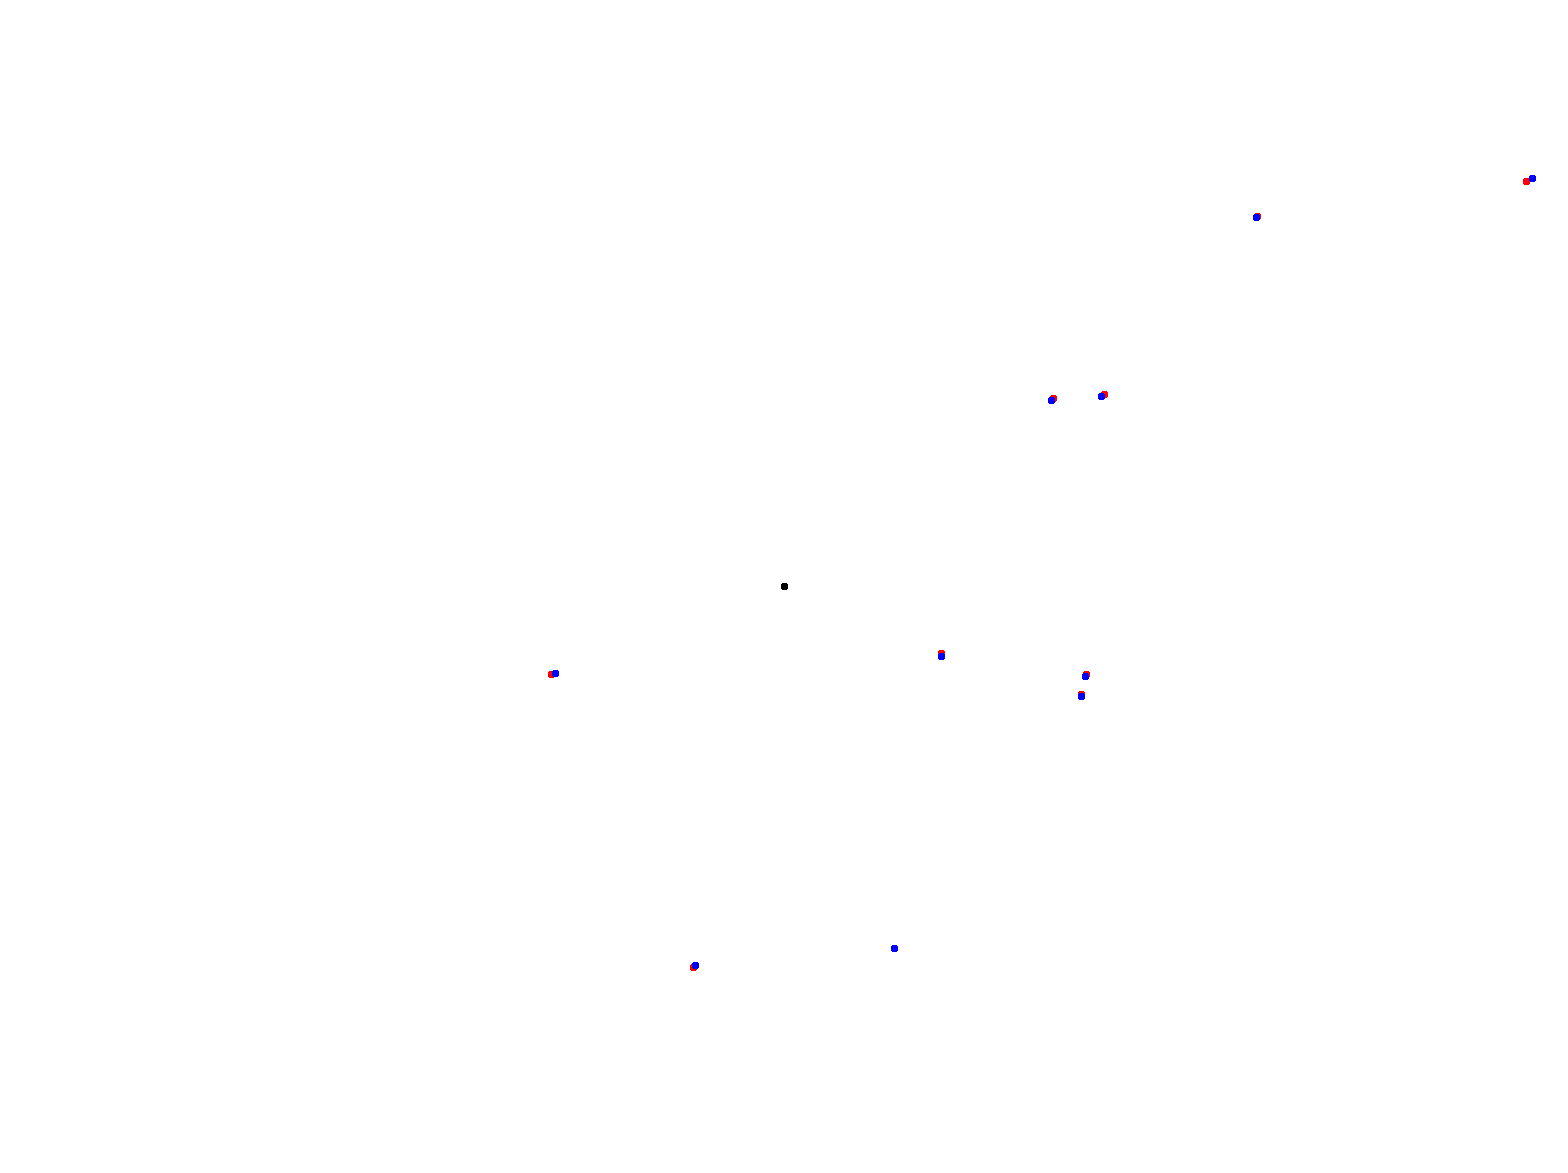

In [123]:
scatter_img

In [124]:
print "Script running time:", time() - start_time

Script running time: 3.06151509285


In [125]:
scatter_img.save(res_folder + date[:-4] + '_scat_aff' + ".jpg")